In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [5]:
region, rat = "STR", "T080"

("STR", "T080")

In [6]:
sessions = filter(x->occursin(rat,x), readdir(path));

In [7]:
output = load.(joinpath.(path, [sessions[2]]), false, delay=0.05);

In [8]:
data = getindex.(output, 1)
μ_rnt = getindex.(output, 2);
μ_t = getindex.(output, 3);

In [9]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [2], [320], 4)

## Fit real data

In [10]:
#θ1 = unflatten(reload(ENV["HOME"]*"/Projects/neural_DDM_analysis/data/results/E021.mat"), 
#        ncells, nparams, f)

In [11]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [12]:
#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0),
#    nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0., 0., 0.01, 0.005], repeat([0.,-10.,-10.,], sum(ncells))), 
#    ub = vcat([2., 30., 5., 100., 2.5, 1.2, 1.], repeat([100.,10.,10.], sum(ncells))))

options0 = neuraloptions(ncells=ncells,
    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008, 0., 0.], θy0),
    nparams=nparams, f=f);

In [13]:
#model = optimize(data, options0, f_tol=1e-9);

In [14]:
fit=vcat(trues(1), trues(8), trues(sum(ncells)*nparams))
#x0=vcat([0.1, 12., -2., 10., 1., 0.4, 0.008], pulse_input_DDM.flatten(model.θ)[dimz+1:end]);
x0=vcat([0.1, 12., -2., 10., 1., 0.4, 0.008, 0., 0.], θy0);

In [28]:
#options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0.,   0.,  0.01, 0.005], repeat([0.,-100.,-100.,], sum(ncells))), 
#    ub = vcat([2., 50., 5., 100., 2.5, 1.2,  1.], repeat([100.,100.,100.], sum(ncells))))

options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f,
    ub = vcat([2., 30., 5., 100., 2.5, 1.0, 1., 30., 30.], repeat([100.,100.,10.,10.], sum(ncells))));

In [29]:
n = 53

53

In [30]:
model = optimize(data, options, n, f_tol=1e-12);

Fminbox
-------
Initial mu = 0.0243866

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0243866

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.833079e+04     4.307757e+03
 * time: 2.6941299438476562e-5
     1     1.829176e+04     4.585444e+03
 * time: 0.8992519378662109
     2     1.672105e+04     9.987835e+02
 * time: 1.596174955368042
     3     1.620026e+04     3.486457e+02
 * time: 2.2989420890808105
     4     1.610656e+04     1.391122e+02
 * time: 2.9782769680023193
     5     1.592607e+04     1.019770e+02
 * time: 3.6635351181030273
     6     1.579446e+04     6.362775e+02
 * time: 4.36553692817688
     7     1.566665e+04     9.032513e+01
 * time: 5.036890029907227
     8     1.554610e+04     1.063649e+02
 * time: 5.723773956298828
     9     1.551844e+04     1.011033e+02
 * time: 6.415215969085693
    10     1.542325e+04     8.998057e+01
 * time: 7.117280960083008
    11     1.535385e+04     9.1493

   117     1.429420e+04     2.145398e+00
 * time: 92.80647993087769
   118     1.429420e+04     2.654084e+00
 * time: 93.82881498336792
   119     1.429420e+04     1.768711e+00
 * time: 94.85320591926575
   120     1.429420e+04     2.558647e+00
 * time: 95.87145900726318
   121     1.429419e+04     4.599707e+00
 * time: 96.89987897872925
   122     1.429419e+04     1.832980e+00
 * time: 97.93008399009705
   123     1.429419e+04     7.684413e-01
 * time: 99.2985029220581
   124     1.429419e+04     7.212503e-01
 * time: 101.01118206977844
   125     1.429419e+04     7.502580e-01
 * time: 102.37871599197388
   126     1.429419e+04     2.219585e+00
 * time: 103.40535998344421
   127     1.429419e+04     2.514773e+00
 * time: 104.436439037323
   128     1.429419e+04     2.973247e+00
 * time: 105.82282495498657
   129     1.429419e+04     3.420272e+00
 * time: 107.21366500854492
   130     1.429418e+04     3.343461e+00
 * time: 107.91288495063782
   131     1.429418e+04     2.851572e+00
 * 

   237     1.429348e+04     4.449738e-01
 * time: 190.19264698028564
   238     1.429348e+04     1.732632e-01
 * time: 190.8834331035614
   239     1.429348e+04     4.924165e-01
 * time: 191.56324410438538
   240     1.429348e+04     2.202888e-01
 * time: 192.58773398399353
   241     1.429348e+04     3.659978e-01
 * time: 193.26716804504395
   242     1.429348e+04     5.120602e-01
 * time: 193.9622790813446
   243     1.429348e+04     4.758661e-01
 * time: 194.65113711357117
   244     1.429348e+04     3.923607e-01
 * time: 195.34773898124695
   245     1.429348e+04     3.694535e-01
 * time: 196.02752208709717
   246     1.429348e+04     3.861782e-01
 * time: 196.7066729068756
   247     1.429348e+04     3.890951e-01
 * time: 197.385174036026
   248     1.429348e+04     3.877853e-01
 * time: 198.06206703186035
   249     1.429348e+04     3.880351e-01
 * time: 198.7430601119995
   250     1.429348e+04     3.871797e-01
 * time: 199.41378688812256
   251     1.429348e+04     3.872842e-01

    88     1.429505e+04     4.129356e-01
 * time: 93.37802696228027
    89     1.429505e+04     4.843741e-01
 * time: 94.12258291244507
    90     1.429505e+04     5.760401e-01
 * time: 95.19261884689331
    91     1.429505e+04     6.455973e-01
 * time: 96.24290800094604
    92     1.429505e+04     6.410173e-01
 * time: 96.92803597450256
    93     1.429505e+04     6.272260e-01
 * time: 97.6616678237915
    94     1.429505e+04     5.882429e-01
 * time: 98.3403639793396
    95     1.429505e+04     6.595606e-01
 * time: 99.05778694152832
    96     1.429505e+04     8.296553e-01
 * time: 99.74749302864075
    97     1.429505e+04     5.448458e-01
 * time: 100.80457282066345
    98     1.429505e+04     4.848424e-01
 * time: 101.53657388687134
    99     1.429505e+04     7.658436e-01
 * time: 104.26796197891235
   100     1.429505e+04     5.983555e-01
 * time: 106.51342391967773
   101     1.429505e+04     8.406388e-01
 * time: 108.97768902778625
   102     1.429505e+04     5.879677e-01
 * t

In [31]:
model.θ.θz

θz{Float64}
  σ2_i: Float64 1.9999999999474534
  B: Float64 21.673080952055727
  λ: Float64 2.473195851874388
  σ2_a: Float64 58.40847501069356
  σ2_s: Float64 2.499999999947069
  ϕ: Float64 1.1999999999946438
  τ_ϕ: Float64 0.7296799050303275
  μ_1: Float64 2.053686891174645
  μ_2: Float64 1.9067482952043742


In [32]:
#θ1.θz

## Sample rates

In [33]:
nconds = 2

2

In [34]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [35]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=nconds);
#μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(θ1, data; num_samples=100, nconds=nconds);

In [36]:
using PyPlot

In [37]:
dt = 1e-2

0.01

In [111]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:nconds   

            ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax.plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax.set_xlim((0, 0.5))
                        
        end   
        
        ax.plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

ErrorException: type Array has no field fill_between

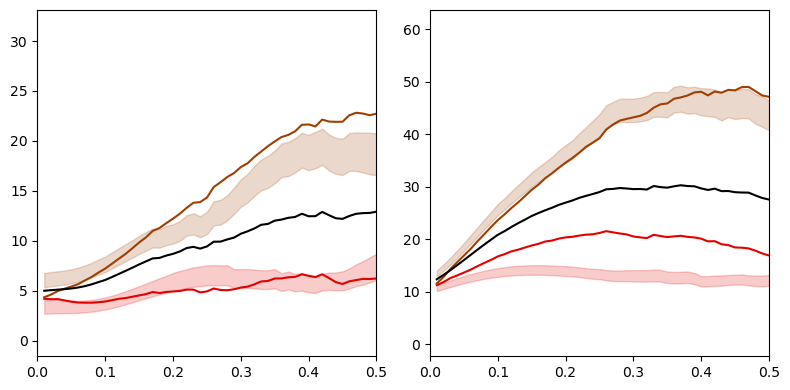

In [38]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:nconds   

            ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[j].set_xlim((0, 0.5))
                        
        end   
        
        ax[j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [112]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:nconds   

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

BoundsError: BoundsError: attempt to access 2-element Array{PyCall.PyObject,1} at index [1, 2]

In [39]:
LL_ML = loglikelihood(model.θ, data, n)
#LL_ML = loglikelihood(θ1, data, n)

-14295.052230966312

In [40]:
LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
        +, 1:data.ncells), +, data), +, data, model.θ.θy)

#LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
#    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
#        +, 1:data.ncells), +, data), +, data, θ1.θy)

-15637.871957281573

In [41]:
LL_ML - LL_null

1342.8197263152615

In [27]:
LL_ML - LL_null

1796.8993979779952

In [117]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

SSx (generic function with 1 method)

In [118]:
1 - SSx(μ_c_λ - μ_ct, 40)/SSx(μ_ct, 40)

0.9739044235299781

In [119]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

┌ Warning: Hessian is not positive definite. Approximated by closest PSD matrix.
│             ||ϵ||/||H|| is 0.07989241360268688
└ @ pulse_input_DDM /usr/people/briandd/Projects/pulse_input_DDM/src/base_model.jl:19


In [120]:
CI

17-element Array{Float64,1}:
   4.218430518295009  
   9.061037078524995  
   1.4661004367431274 
 120.04436150502052   
   2.062958020413626  
   0.23454441044404195
   1.4441393982677233 
   1.6782819888249267 
   1.6189035094804722 
   4.977045516082818  
  45.98891894150826   
   0.11824975128677018
   0.7334654136376239 
   2.9700556837627574 
  37.47929232494586   
   0.07148813230655994
   0.45133659655590624

In [121]:
using LinearAlgebra

In [122]:
vals = eigvals(H)

17-element Array{Float64,1}:
  -136.5191048657985      
     0.0002719719421921455
     0.002399555012189169 
     0.002863239523711165 
     0.1551350268271657   
     0.22229654752763942  
     1.454213522630989    
     1.8956448900682645   
     1.989564666470129    
     2.2687711799475574   
     3.618921864860535    
     7.062883557436005    
     7.837341530686475    
   274.19828771121973     
   525.2836467775945      
 24166.96973413574        
 38358.945189655286       

In [123]:
vecs = eigvecs(H)

17×17 Array{Float64,2}:
 -0.00342602    0.00310942   -0.0236764    …  -0.00145799   -0.00011878 
 -0.00967919   -0.0121311     0.00716804      -0.00320644    0.000612803
 -0.0287525     0.00694615   -0.0143882       -0.0141916     0.0013454  
 -0.000819114  -0.978749     -0.203825        -0.000119938  -6.58207e-6 
 -0.0366666     0.00904961    0.0209393       -0.006915     -0.00053531 
  0.988557      0.000115919  -0.000511116  …   0.0254533    -0.00617397 
  0.0968029    -0.0030881     0.00301638       0.000281511  -0.000276814
 -0.00885611   -0.00526388    0.00323744      -0.00303029    0.000260415
 -0.00597571   -0.00491532    0.00499989      -0.00270487    0.000697986
 -0.0345362     0.0233386    -0.0910737        0.00202395    0.00590232 
 -0.00443483   -0.192795      0.942494     …  -0.00135044    0.0038266  
  0.0236392     0.000527066  -0.00235986      -0.526302      0.846929   
 -0.0784211     0.00239903   -0.0139587       -0.0147715     0.0732277  
 -0.0107077    -0.00338669 

In [124]:
vecs[:,1]

17-element Array{Float64,1}:
 -0.0034260194672688575
 -0.009679190516460877 
 -0.028752498221953537 
 -0.0008191138724778084
 -0.03666661403587633  
  0.9885566527873343   
  0.09680287502341352  
 -0.008856109060159796 
 -0.005975710201767933 
 -0.03453624128299899  
 -0.004434825911440105 
  0.023639241865537015 
 -0.07842108879893926  
 -0.010707717047576094 
 -0.002888079559539164 
  0.01951455212587721  
 -0.05068186354471542  

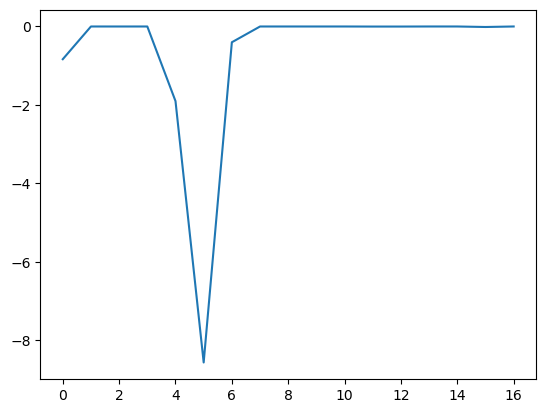

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0dde4fce48>

In [126]:
plot(gradient(model, n))

## generate fake data and plot

In [11]:
output = load.(joinpath.(path, sessions[end-2:end]), false, delay=0.05);

In [12]:
data = getindex.(output, 1);

In [13]:
#f, ncells, ntrials, nparams = "Softplus", map(x-> x[1].ncells, data), length.(data), 3
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [1, 1, 1], [255, 357, 553], 4)

In [63]:
#θ_syn = θneural(θz = θz(σ2_i = 0.5, B = 40., λ = -0.5, σ2_a = 50., σ2_s = 0.1,
#    ϕ = 0.6, τ_ϕ =  0.02),
#    θy=[[Softplus(10., rand([-1.,1.]),0.) for n in 1:N] for N in ncells], ncells=ncells,
#    nparams=nparams, f=f)
θ_syn = θneural(θz = θz(σ2_i = 0.0001, B = 40., λ = -0.01, σ2_a = 0.000001, σ2_s = 0.00001,
    ϕ = 1. -0.00001, τ_ϕ =  0.02, μ_1 = -10.0, μ_2 = 10.0),
    θy=[[Sigmoid(-20., 20., 0.1 * rand([-1.,1.]), 0.) for n in 1:N] for N in ncells], ncells=ncells,
    nparams=nparams, f=f)

θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  θz: θz{Float64}
  θy: Array{Array{Sigmoid{Float64},1}}((3,))
  ncells: Array{Int64}((3,)) [1, 1, 1]
  nparams: Int64 4
  f: String "Sigmoid"


In [64]:
data, μ_rnt, μ_t = synthetic_data(θ_syn, ntrials; centered=true);

In [65]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=2);

In [66]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [67]:
μ_λ, μ_c_λ, λ = pulse_input_DDM.synthetic_λ(θ_syn, data; num_samples=100, nconds=2);

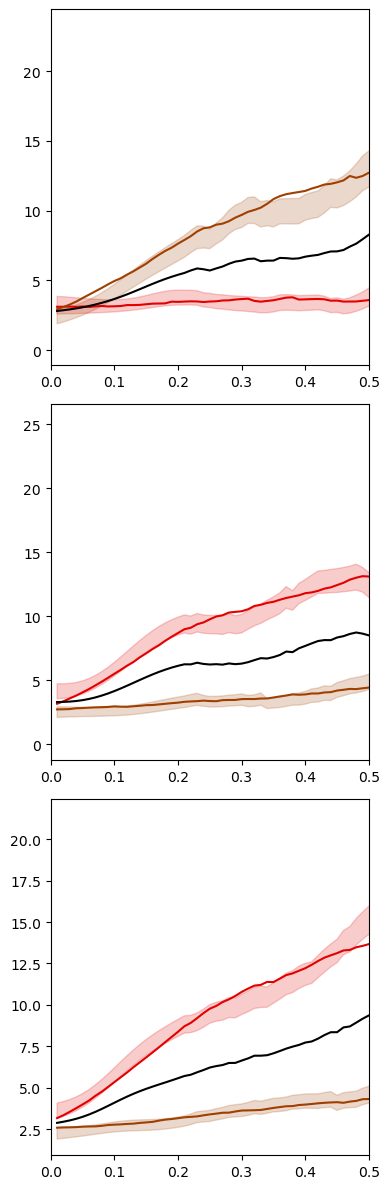

In [68]:
using PyPlot

dt =1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 

In [69]:
a = pulse_input_DDM.synthetic_a(θ_syn, data; num_samples=1);

In [70]:
choice = map(x-> x.choice, data[1]);

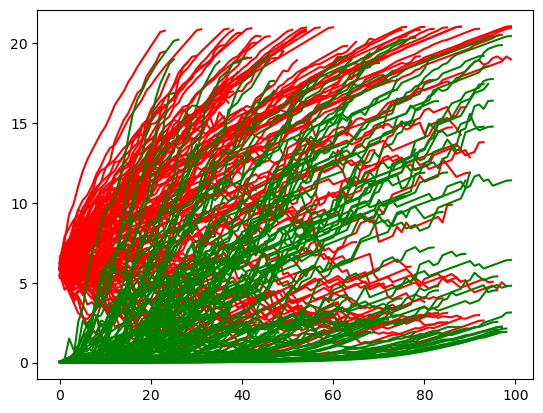

In [71]:
plot.(map(x-> x[1], λ[1][1][findall(choice[1:end-1] .== true) .+ 1]), color="red")
plot.(map(x-> x[1], λ[1][1][findall(choice[1:end-1] .== false) .+ 1]), color="green");

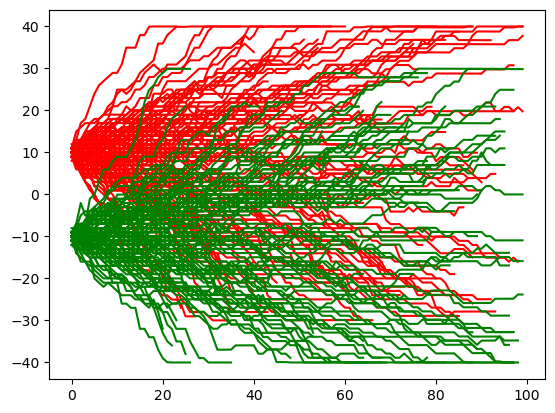

In [72]:
plot.(a[1][1][findall(choice[1:end-1] .== true) .+ 1], color="red")
plot.(a[1][1][findall(choice[1:end-1] .== false) .+ 1], color="green");

In [73]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [80]:
#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0),
#    nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0., 0., 0.01, 0.005], repeat([0.,-10.,-10.,], sum(ncells))), 
#    ub = vcat([2., 30., 5., 100., 2.5, 1.2, 1.], repeat([100.,10.,10.], sum(ncells))))

#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat(pulse_input_DDM.flatten(θ_syn)[1:dimz], θy0),
#    nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0., 0., 0.01, 0.005], repeat([0.,-10.,-10.,], sum(ncells))), 
#    ub = vcat([2., 30., 5., 100., 2.5, 1.2, 1.], repeat([100.,10.,10.], sum(ncells))))

#options = neuraloptions(ncells=ncells, 
#    x0=vcat(pulse_input_DDM.flatten(θ_syn)[1:dimz], θy0),
#    fit=vcat(trues(dimz), trues(sum(ncells)*nparams)), nparams=nparams, f=f, 
#    lb = vcat([0., 8., -5., 0.,   0.,  0.01, 0.005], repeat([0.,-100.,-100.,], sum(ncells))), 
#    ub = vcat([2., 50., 5., 100., 2.5, 1.2,  1.], repeat([100.,100.,100.], sum(ncells))))

options = neuraloptions(ncells=ncells, 
    x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008, 0., 0.,], θy0),
    fit=vcat(trues(dimz), trues(sum(ncells)*nparams)), nparams=nparams, f=f)

#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=vcat(pulse_input_DDM.flatten(θ_syn)[1:dimz], θy0),
#    nparams=nparams, f=f)

#options0 = neuraloptions(ncells=ncells,
#    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
#    x0=pulse_input_DDM.flatten(θ_syn),
#    nparams=nparams, f=f)

neuraloptions
  ncells: Array{Int64}((3,)) [1, 1, 1]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((21,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((21,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, -30.0, -30.0, -100.0  …  -10.0, -10.0, -100.0, 0.0, -10.0, -10.0, -100.0, 0.0, -10.0, -10.0]
  ub: Array{Float64}((21,)) [2.0, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 30.0, 30.0, 100.0  …  10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 100.0, 100.0, 10.0, 10.0]
  x0: Array{Float64}((21,)) [0.1, 12.0, -2.0, 10.0, 0.1, 0.8, 0.008, 0.0, 0.0, 2.3255813953488373  …  0.0024839181143618454, 0.0, 2.190721649484536, 17.138351832943577, -0.0030400562857546757, 0.0, 2.162565249813572, 17.463602974485493, -0.003105532323723156, 0.0]


In [81]:
n = 53
loglikelihood(θ_syn, data, n)

-15901.210671729124

In [82]:
model = optimize(data, options, n; f_tol=1e-9)

Fminbox
-------
Initial mu = 0.0179321

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0179321

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.528614e+04     1.744598e+03
 * time: 3.910064697265625e-5
     1     2.512749e+04     1.671755e+03
 * time: 3.343536138534546
     2     2.508813e+04     8.948165e+03
 * time: 6.561738014221191
     3     2.412472e+04     8.589831e+02
 * time: 9.769048929214478
     4     2.368039e+04     9.163366e+02
 * time: 12.919588088989258
     5     2.362630e+04     9.233643e+02
 * time: 16.049148082733154
     6     2.361548e+04     9.317274e+02
 * time: 19.20145297050476
     7     2.359410e+04     9.288869e+02
 * time: 22.346485137939453
     8     2.358886e+04     9.281895e+02
 * time: 25.452331066131592
     9     2.350484e+04     2.151362e+03
 * time: 28.62055206298828
    10     2.350201e+04     6.087451e+03
 * time: 31.750947952270508
    11     2.349117e+04     1.045

   117     1.599874e+04     3.743101e+01
 * time: 380.14260601997375
   118     1.599838e+04     6.813541e+01
 * time: 383.30939412117004
   119     1.599801e+04     2.262424e+01
 * time: 386.4921100139618
   120     1.599773e+04     4.243404e+01
 * time: 389.64646005630493
   121     1.599741e+04     1.979973e+01
 * time: 392.79855012893677
   122     1.599700e+04     2.830041e+01
 * time: 395.98248505592346
   123     1.599655e+04     1.890511e+01
 * time: 399.1397850513458
   124     1.599595e+04     3.212674e+01
 * time: 402.3050000667572
   125     1.599537e+04     1.738302e+01
 * time: 405.5352051258087
   126     1.599472e+04     1.843764e+01
 * time: 408.73087096214294
   127     1.599402e+04     1.924483e+01
 * time: 411.94662714004517
   128     1.599309e+04     3.509470e+01
 * time: 415.15164399147034
   129     1.599216e+04     1.840344e+01
 * time: 418.34476804733276
   130     1.599110e+04     1.816487e+01
 * time: 421.5097849369049
   131     1.599005e+04     1.944195e+0

   238     1.588896e+04     1.355314e+02
 * time: 772.6523520946503
   239     1.588865e+04     1.010703e+02
 * time: 775.8290050029755
   240     1.588835e+04     1.034365e+02
 * time: 779.0197401046753
   241     1.588810e+04     8.861203e+01
 * time: 782.2857110500336
   242     1.588798e+04     7.917423e+01
 * time: 785.447704076767
   243     1.588787e+04     8.532913e+01
 * time: 788.6303689479828
   244     1.588766e+04     6.890757e+01
 * time: 791.86580991745
   245     1.588756e+04     4.179244e+01
 * time: 795.2065041065216
   246     1.588737e+04     1.273656e+02
 * time: 798.410404920578
   247     1.588727e+04     1.733172e+02
 * time: 801.5898110866547
   248     1.588725e+04     6.406981e+03
 * time: 805.0496361255646
   249     1.588707e+04     2.002717e+02
 * time: 808.4436480998993
   250     1.588687e+04     1.420275e+02
 * time: 811.669408082962
   251     1.588674e+04     1.437138e+02
 * time: 815.0076100826263
   252     1.588673e+04     1.607642e+02
 * time: 818

   359     1.588469e+04     3.743987e+00
 * time: 1203.7744290828705
   360     1.588469e+04     1.375574e+01
 * time: 1208.7120730876923
   361     1.588469e+04     2.915626e+00
 * time: 1212.0941801071167
   362     1.588469e+04     4.786235e+00
 * time: 1215.2932000160217
   363     1.588469e+04     2.688771e+00
 * time: 1218.5668139457703
   364     1.588469e+04     3.828886e+00
 * time: 1221.7710361480713
   365     1.588469e+04     3.564310e+00
 * time: 1225.0103750228882
   366     1.588469e+04     8.216864e-01
 * time: 1228.207111120224
   367     1.588469e+04     2.644566e+00
 * time: 1231.41543507576
   368     1.588469e+04     3.267322e+00
 * time: 1234.5910589694977
   369     1.588469e+04     2.359332e+00
 * time: 1237.8243811130524
   370     1.588469e+04     3.803456e+00
 * time: 1241.0551359653473
   371     1.588469e+04     2.836703e+00
 * time: 1244.787013053894
   372     1.588468e+04     4.177841e+00
 * time: 1247.9866020679474
   373     1.588468e+04     2.302630e+

optimization complete. converged: true 



neuralDDM{θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((3,))


In [86]:
model.θ.θz

θz{Float64}
  σ2_i: Float64 0.0476111781781709
  B: Float64 24.693791131268696
  λ: Float64 -0.019220092929418602
  σ2_a: Float64 0.0017330324594213437
  σ2_s: Float64 4.2450786271709117e-8
  ϕ: Float64 0.9946733092314822
  τ_ϕ: Float64 0.999693823636501
  μ_1: Float64 -9.520345983169095
  μ_2: Float64 9.52299600607487


In [87]:
model.θ.θy

3-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -21.0795920573325
  b: Float64 21.838540535030354
  c: Float64 0.08284861905964593
  d: Float64 -0.02948200082308665
]   
 [Sigmoid{Float64}
  a: Float64 -30.143178391613873
  b: Float64 67.37083847869717
  c: Float64 -0.02935454845786478
  d: Float64 -0.8808284229997085
]  
 [Sigmoid{Float64}
  a: Float64 -22.350654608595555
  b: Float64 26.855542917410304
  c: Float64 -0.07077512262061993
  d: Float64 -0.17047518095083553
]

In [83]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=2);

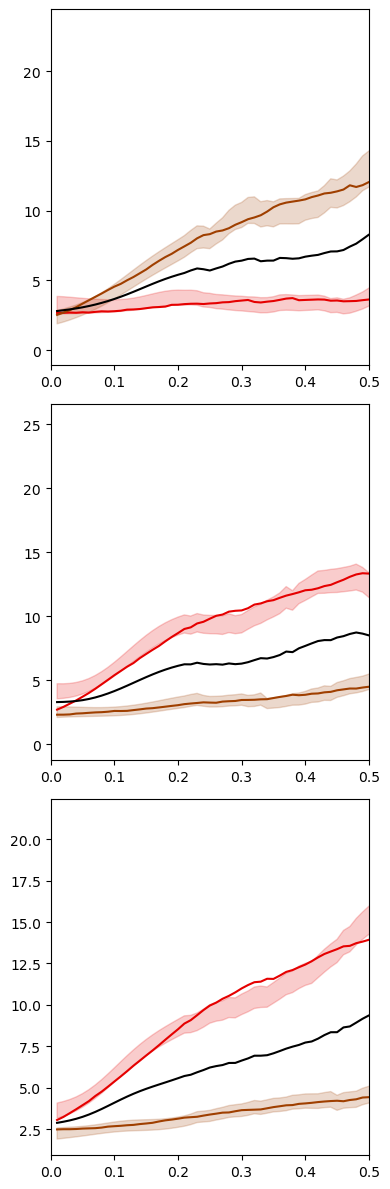

In [84]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout() 